# Transactions - Data Integration

In [1]:
import os

import joblib
import numpy as np
import pandas as pd
import skops.io as sio
from tqdm import tqdm

import helpers
from helpers import (
    CHARTS_DIR, ENCODER_MODEL_DIR, RAW_DATA_DIR, TRANSFORMED_DATA_DIR
)

import plotly.express as px
import plotly.graph_objects as go

## Load imputed data and decode encoding

In [2]:
encoder_path = ENCODER_MODEL_DIR / 'one_hot_encoder_township_building_type_tenure.joblib'

if os.path.exists(encoder_path):
    ohe = joblib.load(encoder_path)
else:
    raise Exception(f'Encoder not found at {encoder_path}')

In [3]:
df_imputed = pd.read_parquet(TRANSFORMED_DATA_DIR / 'transactions_KL_ckpt5_multi_imputed_bayesianridge.parquet')
df_imputed = ohe.inverse_transform(df_imputed)

In [4]:
type_conversion = {
    'township': 'category',
    'building_type': 'category',
    'tenure': 'category',
    'floors': 'int',
    'rooms': 'int',
    'land_area': 'float',
    'built_up': 'float',
    'price_psf': 'float',
    'price': 'float',
    'year': 'int',
    'month': 'int',
    'day': 'int'
}

for column, dtype in type_conversion.items():
    df_imputed[column] = df_imputed[column].astype(dtype)

df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265270 entries, 0 to 265269
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   township       265270 non-null  category
 1   building_type  265270 non-null  category
 2   tenure         265270 non-null  category
 3   floors         265270 non-null  int32   
 4   rooms          265270 non-null  int32   
 5   land_area      265270 non-null  float64 
 6   built_up       265270 non-null  float64 
 7   price_psf      265270 non-null  float64 
 8   price          265270 non-null  float64 
 9   year           265270 non-null  int32   
 10  month          265270 non-null  int32   
 11  day            265270 non-null  int32   
dtypes: category(3), float64(4), int32(5)
memory usage: 14.2 MB


## Load and visualise economic indicators for integration

### Overnight Policy Rate (OPR) / Interest Rates

Source:
1. Bank Negara Malaysia: https://www.bnm.gov.my/monetary-stability/opr-decisions
2. Reuters: https://www.reuters.com/article/malaysia-economy-rates-idINKLR43945120090224

In [5]:
df_opr = pd.read_excel(RAW_DATA_DIR / 'bnm-opr_historical-1998-2023.xlsx')
df_opr['date'] = pd.to_datetime(df_opr['date'])
df_opr.head()

,date,opr_change_percentage,new_opr_percentage
0,2023-07-06,0,3.00
1,2023-05-03,+0.25,3.00
2,2023-03-09,0,2.75
3,2023-01-19,0,2.75
4,2022-11-03,+0.25,2.75


<Axes: title={'center': 'Historical Overnight Policy Rate (OPR) from 1998 to 2023'}, xlabel='date'>

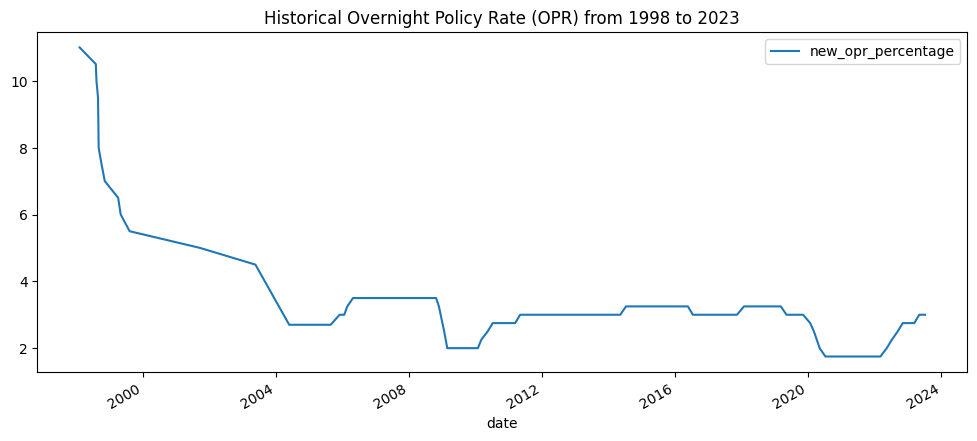

In [6]:
df_opr.sort_values(by='date').plot(
    x='date',
    y='new_opr_percentage',
    figsize=(12,5),
    title='Historical Overnight Policy Rate (OPR) from 1998 to 2023'
)

We have adequate data for interest rates.

### Consumer Price Index

In [7]:
df_annual_cpi = pd.read_excel(RAW_DATA_DIR / 'wb-annual-cpi-1960-2022.xlsx', sheet_name='Data', skiprows=3)
df_annual_cpi = df_annual_cpi.query("`Country Name` == 'Malaysia'").drop(columns=['Country Name', 'Country Code', 'Indicator Code']).T
df_annual_cpi = df_annual_cpi.iloc[1:].reset_index()
df_annual_cpi.columns = ['Year', 'Consumer price index (2010 = 100)']
df_annual_cpi.head()

,Year,Consumer price index (2010 = 100)
0,1960,21.309241
1,1961,21.270798
2,1962,21.293864
3,1963,21.955092
4,1964,21.866672


In [8]:
df_monthly_cpi = pd.read_csv(RAW_DATA_DIR / 'dosm-monthly-cpi-2010-2023.csv')
df_monthly_cpi['date'] = pd.to_datetime(df_monthly_cpi['date'])
df_monthly_cpi.tail()

,date,overall,food_beverage,alcohol_tobacco,clothing_footwear,housing_utilities,furnishings,health,transport,communication,recreation_culture,education,hospitality,misc
158,2023-03-01,129.9,151.3,170.9,93.5,124.7,125.3,127.5,120.0,96.1,116.3,124.1,146.2,120.9
159,2023-04-01,130.0,151.1,171.0,93.5,124.7,125.3,127.5,120.4,96.1,116.7,124.3,146.0,121.4
160,2023-05-01,130.2,151.8,171.1,93.5,125.3,125.5,127.6,120.2,93.9,117.1,124.6,146.9,121.9
161,2023-06-01,130.4,151.9,171.1,93.4,125.3,125.5,127.9,120.5,94.0,117.4,124.7,147.1,122.1
162,2023-07-01,130.5,152.5,171.1,93.5,125.3,125.7,128.2,120.6,93.9,117.1,124.9,147.6,122.0


In [9]:
mean_cpi_2023 = df_monthly_cpi.query("'2021-01-01' <= date <= '2021-12-31'")['overall'].mean()
mean_cpi_2023

123.075

In [10]:
df_annual_cpi.loc[len(df_annual_cpi)] = [2023, mean_cpi_2023]
df_annual_cpi.tail()

,Year,Consumer price index (2010 = 100)
59,2019,121.463089
60,2020,120.079987
61,2021,123.054491
62,2022,127.212131
63,2023.0,123.075


<Axes: title={'center': 'Malaysia Consumer Price Index from 1960 to 2023 (2010 = 100)'}, xlabel='Year'>

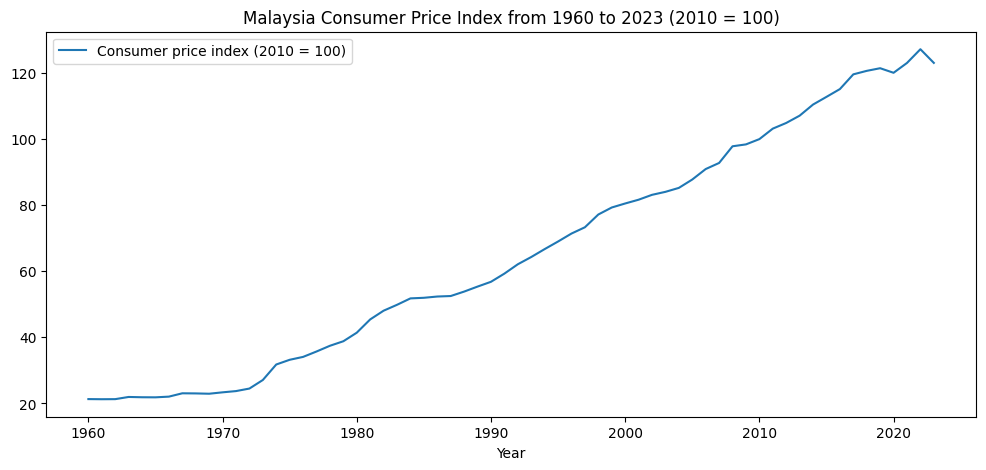

In [11]:
df_annual_cpi.plot(
    x='Year',
    y='Consumer price index (2010 = 100)',
    figsize=(12,5),
    title='Malaysia Consumer Price Index from 1960 to 2023 (2010 = 100)'
)

### Household Income and Number of Households

Source:
1. DOSM
2. Free Malaysia Today: https://www.freemalaysiatoday.com/category/nation/2023/07/28/average-income-per-household-up-2-4-to-rm8489/

Require forecasting for 2022 and 2023 of number of households.

In [12]:
df_income = pd.read_csv(RAW_DATA_DIR / 'dosm-households_and_income_by_state-1984-2022.csv')
df_income = df_income.query("state == 'W.P. Kuala Lumpur'").reset_index(drop=True)
df_income['date'] = pd.to_datetime(df_income['date']).dt.year
df_income['n_households'] = df_income['n_households'] * 1000
df_income.head()

,date,state,n_households,median,mean,gini
0,1970,W.P. Kuala Lumpur,NaN,NaN,NaN,NaN
1,1974,W.P. Kuala Lumpur,NaN,NaN,NaN,NaN
2,1976,W.P. Kuala Lumpur,NaN,NaN,1058.0,NaN
3,1979,W.P. Kuala Lumpur,NaN,NaN,NaN,NaN
4,1984,W.P. Kuala Lumpur,NaN,NaN,1920.0,0.4856


In [13]:
df_income.loc[len(df_income)] = [2023, 'W.P. Kuala Lumpur', None, 10234, 13325, None]
df_income.tail()

C:\Users\USER\AppData\Local\Temp\ipykernel_1276\2039805131.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_income.loc[len(df_income)] = [2023, 'W.P. Kuala Lumpur', None, 10234, 13325, None]


,date,state,n_households,median,mean,gini
16,2014,W.P. Kuala Lumpur,440480.0,7620.0,10629.0,0.407000
17,2016,W.P. Kuala Lumpur,461600.0,9073.0,11692.0,0.378327
18,2019,W.P. Kuala Lumpur,484300.0,10549.0,13257.0,0.350000
19,2022,W.P. Kuala Lumpur,553000.0,10234.0,13325.0,0.380000
20,2023,W.P. Kuala Lumpur,NaN,10234.0,13325.0,NaN


<Axes: title={'center': 'Household Income in Kuala Lumpur from 1984 to 2023'}, xlabel='date'>

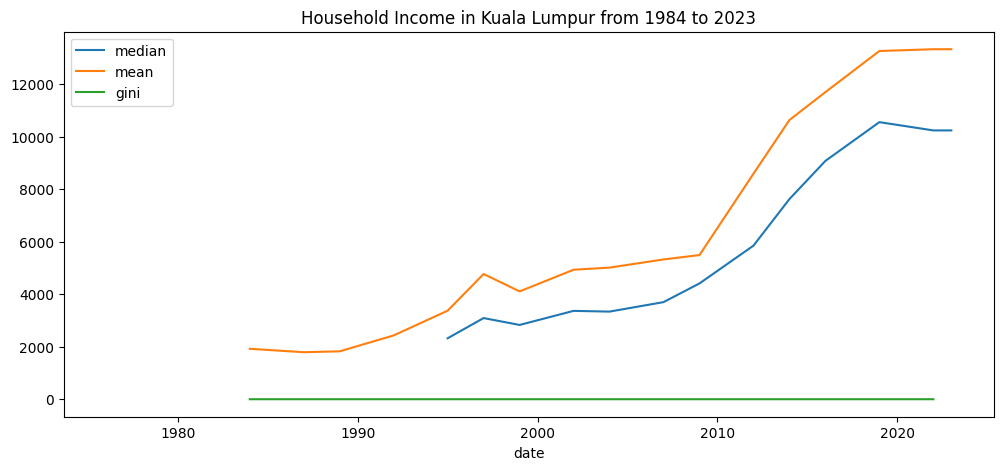

In [14]:
df_income.plot(
    x='date',
    y=['median', 'mean', 'gini'],
    figsize=(12,5),
    title='Household Income in Kuala Lumpur from 1984 to 2023'
)

<Axes: title={'center': 'Number of Households in Kuala Lumpur from 1984 to 2022'}, xlabel='date'>

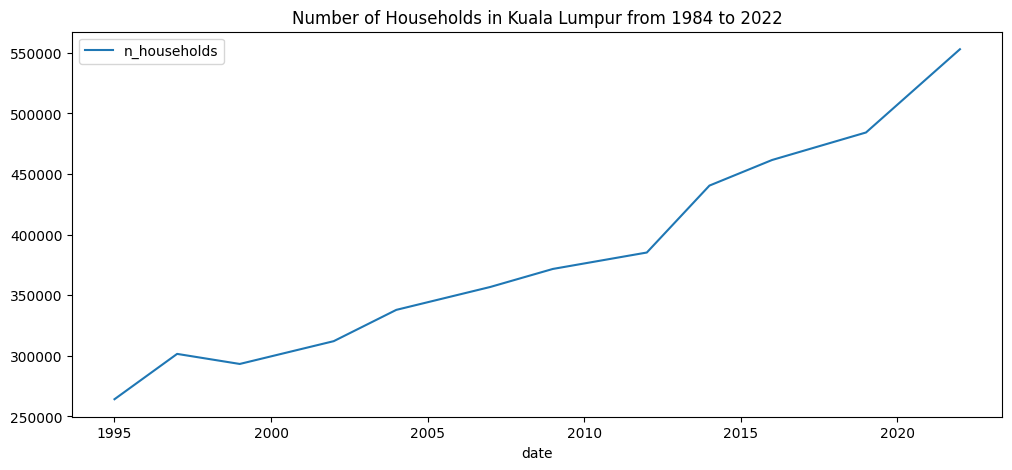

In [15]:
df_income.plot(
    x='date',
    y='n_households',
    figsize=(12,5),
    title='Number of Households in Kuala Lumpur from 1984 to 2022'
)

### Well-being Index

Require forecasting for 2022 and 2023.

In [16]:
df_wellbeing = pd.read_csv(RAW_DATA_DIR / 'dosm-malaysian_wellbeing_index-2000-2021.csv')
df_wellbeing.head()

,Component,Sub Component,Year,Index
0,Economic Well-being,Total,2000,100.0
1,Economic Well-being,Total,2001,100.2
2,Economic Well-being,Total,2002,101.5
3,Economic Well-being,Total,2003,104.2
4,Economic Well-being,Total,2004,105.8


<Axes: title={'center': 'Malaysian Well-being Index from 2000 to 2021'}, xlabel='Year'>

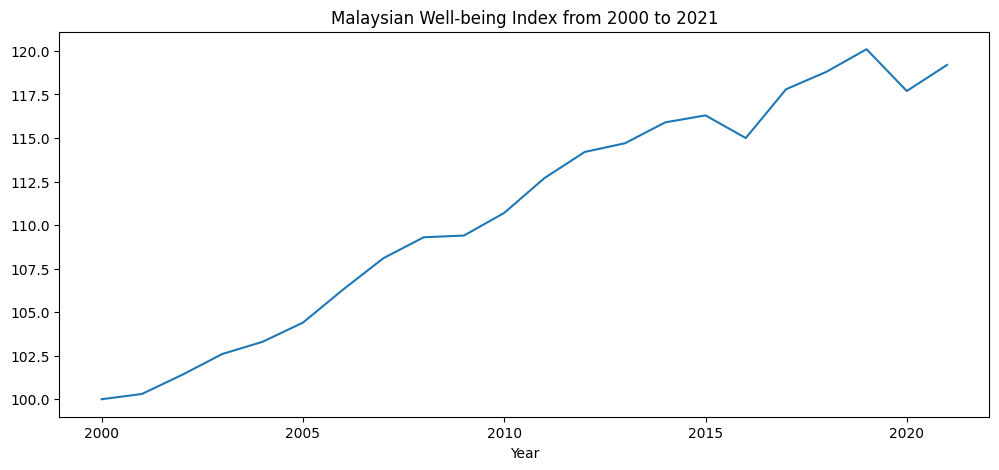

In [17]:
df_wellbeing.query("`Component` == 'Malaysian Well-being Index'").plot(
    x='Year',
    y='Index',
    figsize=(12,5),
    title='Malaysian Well-being Index from 2000 to 2021',
    legend=False
)

### Money Supply (M3)

Source:
1. DOSM: https://archive.data.gov.my/data/ms_MY/dataset/total-money-supply
2. BNM: https://www.bnm.gov.my/publications/mhs

In [18]:
df_money = pd.read_csv(RAW_DATA_DIR / 'dosm-total_money_supply-2000-2023.csv')
df_money = df_money.query("`Monetary Aggregat` == 'M3'")
df_money.head()

,Year,Monetary Aggregat,Money Supply,Category,RM Million
72,2000,M3,Broad money supply,n.a.,458363.1
73,2001,M3,Broad money supply,n.a.,471730.5
74,2002,M3,Broad money supply,n.a.,504150.2
75,2003,M3,Broad money supply,n.a.,553058.4
76,2004,M3,Broad money supply,n.a.,621225.8


<Axes: title={'center': 'Malaysia Total Money Supply (M3) from 2000 to 2023'}, xlabel='Year'>

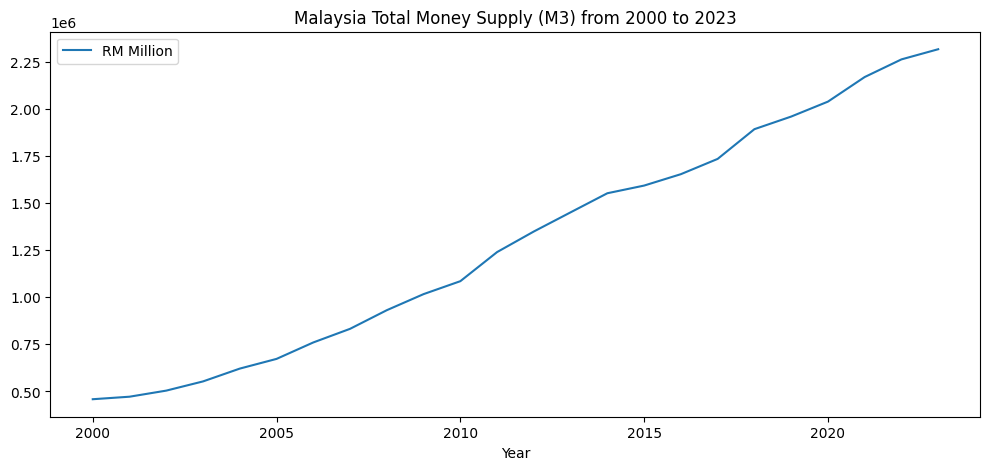

In [19]:
df_money.plot(
    x='Year', 
    y='RM Million', 
    figsize=(12,5),
    title='Malaysia Total Money Supply (M3) from 2000 to 2023',
)

We will use time series methods to backcast money supply M3 values for 2000 to 2013.

### Unemployment Rate

Source:
1. Annual data - DOSM: https://data.gov.my/data-catalogue/labour_labourforce_annual_5
2. Monthly data - DOSM: https://data.gov.my/data-catalogue/labour_labourforce_monthly_5

In [20]:
df_unemployment = pd.read_csv(RAW_DATA_DIR / 'dosm-unemployment_rate-1982-2023.csv')
df_unemployment['date'] = pd.to_datetime(df_unemployment['date'])
df_unemployment.head()

,date,lf_size,employed,unemployed,outside,u_rate,p_rate,ep_ratio
0,1982-01-01,5431.4,5249.0,182.4,2944.6,3.4,64.8,62.67
1,1983-01-01,5671.8,5457.0,214.9,2969.4,3.8,65.6,63.15
2,1984-01-01,5862.5,5566.7,295.8,3119.6,5.0,65.3,61.98
3,1985-01-01,5990.1,5653.4,336.8,3124.9,5.6,65.7,62.02
4,1986-01-01,6222.1,5760.1,461.9,3188.3,7.4,66.1,61.21


<Axes: title={'center': 'Unemployment Rate in Malaysia from 1982 to 2023'}, xlabel='date'>

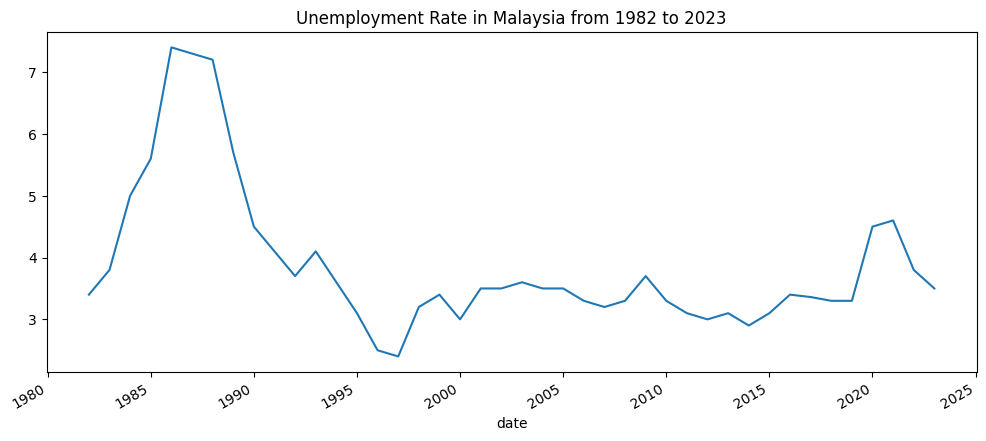

In [21]:
df_unemployment.plot(
    x='date',
    y='u_rate',
    figsize=(12,5),
    title='Unemployment Rate in Malaysia from 1982 to 2023',
    legend=False
)

### Population

Source:
1. Population by state 1980-2020 - DOSM: https://archive.data.gov.my/data/ms_MY/dataset/population-by-age-sex-and-ethnic-group-wp-kuala-lumpur
2. Population by state 2020-2023 - DOSM: https://open.dosm.gov.my/data-catalogue/population_population_state_0?state=w.p.-kuala-lumpur

In [22]:
df_population = pd.read_excel(RAW_DATA_DIR / 'dosm-population_KL-2000-2023.xlsx', skiprows=1)
df_population = df_population.rename(columns={
    'Unnamed: 0': 'Year',
    'Unnamed: 1': 'State',
    'Female': "Female ('000)",
    'Male': "Male ('000)",
    'Total': "Total ('000)"
})
df_population.head()

,Year,State,Administrative District,Female ('000),Male ('000),Total ('000)
0,2000,W.P. Kuala Lumpur,N.A,695.8,720.2,1416.0
1,2001,W.P. Kuala Lumpur,N.A,710.1,736.1,1446.2
2,2002,W.P. Kuala Lumpur,N.A,723.5,750.6,1474.1
3,2003,W.P. Kuala Lumpur,N.A,735.9,764.6,1500.5
4,2004,W.P. Kuala Lumpur,N.A,748.3,778.1,1526.4


<Axes: title={'center': "Population in Kuala Lumpur from 2000 to 2023 ('000)"}, xlabel='Year'>

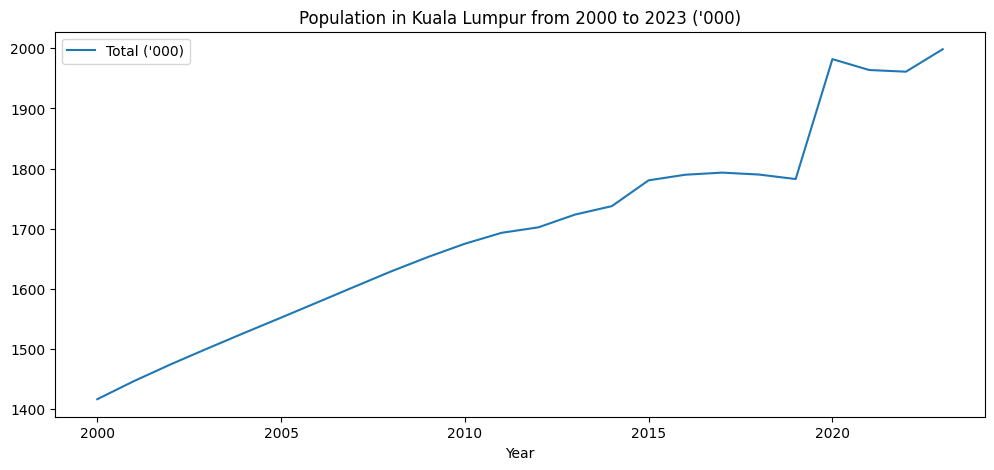

In [23]:
df_population.plot(
    x='Year', 
    y="Total ('000)", 
    figsize=(12,5),
    title="Population in Kuala Lumpur from 2000 to 2023 ('000)"
)

### Crime Rate

Source:
1. Violent crime by contingent, PDRM district and type of crime - DOSM: https://archive.data.gov.my/data/ms_MY/dataset/violent-crime-by-contingent-pdrm-district-and-type-of-crime-malaysia

In [24]:
df_crime = pd.read_csv(RAW_DATA_DIR / 'dosm-number_of_crime_by_state-2015-2021.csv')
df_crime = df_crime.query("`State` == 'W.P. Kuala Lumpur'").reset_index(drop=True)
df_crime = df_crime.groupby('Year').sum().reset_index()
df_crime = df_crime.drop(columns=['State', 'Contingent PDRM District', 'Type of Crime'])
df_crime

,Year,Number of Crime
0,2015,3646
1,2016,3201
2,2017,3372
3,2018,2837
4,2019,2891
5,2020,1937
6,2021,1450


<Axes: title={'center': 'Number of Crime in Kuala Lumpur from 2015 to 2021'}, xlabel='Year'>

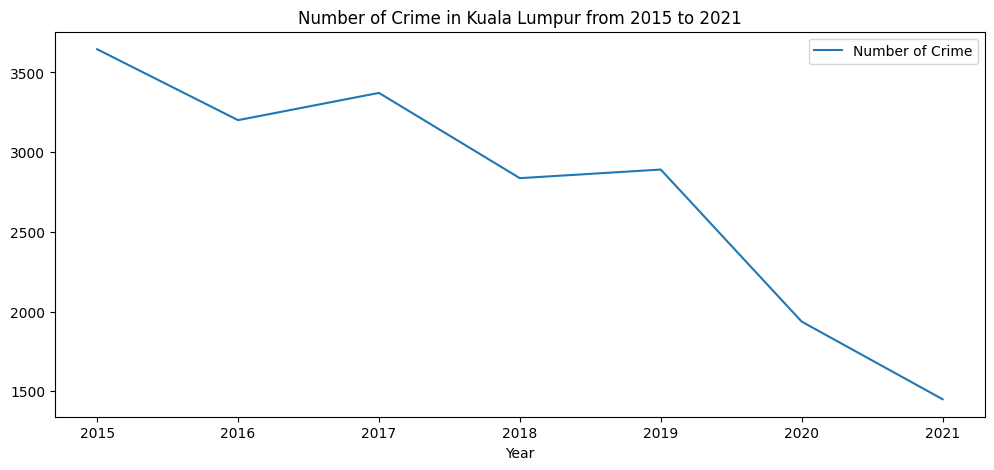

In [25]:
df_crime.plot(
    x='Year',
    y='Number of Crime', 
    figsize=(12,5),
    title='Number of Crime in Kuala Lumpur from 2015 to 2021'
)

We will use linear extrapolation to extrapolate values for total crime from 2000 to 2023.

The data period of the economic indicators:
- BNM OPR: 1998-2023
- DOSM CPI: 1960-2023
- DOSM household income: 1984-2023
- DOSM number of households: 1984-2022
- DOSM wellbeing index: 2000-2021
- DOSM total money supply: 2000-2023
- DOSM unemployment rate: 1982-2023
- DOSM population: 2000-2023
- DOSM crime rate: 2015-2021

The data period of economic indicators are not consistent. Although the transaction data period starts from 1909 and it is also good to have a longer data period, the economic indicators are not available for the whole period. Thus a start year and end year must be selected. Number of transactions from 1957 to 2020 is 247,541 while the number of transactions from 2000 to 2020 is 212,548. The data from 2000 to 2020 takes up 86% of the data from 1957 to 2020, which is an acceptable range given that the economic indicators are mostly in 2000s.

Combined with the significance of the Millennia (Year 2000), the data period of the economic indicators will be limited to 2000-2020. THe prediction period will be 2021-2023.

Thus, the values of the following economic indicators will need to be forecasted and backcasted:
1. Number of households: 2023
2. Wellbeing index: 2022-2023
3. Crime rate: 2000-2016, 2022-2023

## Extrapolating and backcasting economic indicators

Due to the insufficient data period of the economic indicators, the data will need to be extrapolated, as noted in the United Nation's working paper titled "A weighted extrapolation method for measuring the SDGs progress" (Nia, 2017). Based on discovered literature, there are two main methods:
1. Time-weighted extrapolation (Nia, 2017)
2. Spline extrapolation (International Monetary Fund, 2023)

In this study, we use the time-weighted extrapolation as proposed by Nia (2017), despite the Spline extrapolation being used in the Malaysian context by IMF in the 2023 press release. The reasons are:
1. The press release did not specify the implementation details of the Spline extrapolation, which makes it difficult to replicate the results.
2. In the press release, it was stated that, quote "We applied Spline extrapolation to quarterly data to obtain monthly figures.". However, using quarterly data (sparser) to obtain monthly figures (less sparse than quarterly data) is interpolation, instead.
3. Based on Scipy documentation, extrapolation is not fully supported, thus it is difficult to replicate the results.
4. Nia (2017) included its implementation details in the working paper, which makes it easier to replicate the results.

Based on Nia (2017), the best extrapolation method were identified, using voting system, for each of the indicator with missing data:
1. Number of households: Log-transformed regression
2. Wellbeing index: Time-weighted log-transformed regression
3. Crime rate: Time-weighted geometric mean

### Forecasting
There are multiple methods for forecasting the economic indicators. The procedures for each extrapolation method are as detailed below.

#### Log-transformed Regression
1. The indicator I is converted to Y by dividing it by an appropriate scale to standardize it to a scale of 0 to 1.
    - Indicators shown in percentage are divided by 100 and indicators expressed in other rates such as “per 1000”, “per 100,000” divided accordingly by 1000 and 100,000. For some indicators that cannot be expressed in the form of probability or rate, no transformation is applied.
2. A natural log transformation is applied to indicators that needed transformation in the Step 1.
3. Normalise each year by subtracting the mean year.
4. Fit a linear regression model to the transformed data.
5. Obtain the slope, intercept and standard error from the fitted model.
6. Use the slope and intercept to extrapolate the indicator.

#### Time-weighted Log-transformed Regression
1. The indicator I is converted to Y by dividing it by an appropriate scale to standardize it to a scale of 0 to 1.
    - Indicators shown in percentage are divided by 100 and indicators expressed in other rates such as “per 1000”, “per 100,000” divided accordingly by 1000 and 100,000. For some indicators that cannot be expressed in the form of probability or rate, no transformation is applied.
2. A natural log transformation is applied to indicators that needed transformation in the Step 1.
3. Compute the corresponding weights for each observation. 
4. Sum all the weights.
5. Normalise each year by subtracting the mean year.
6. Compute the slope using weights from Step 1 and 2, and the normalised year in Step 3.
7. Use the time-weighted slope and intercept from normal log-transformed regression to extrapolate the indicator.

In [26]:
df_households = df_income[['date', 'n_households']]
df_households = df_households.dropna().reset_index(drop=True)
df_households

,date,n_households
0,1995,264200.0
1,1997,301600.0
2,1999,293300.0
3,2002,312100.0
4,2004,337930.0
5,2007,356818.0
6,2009,371702.0
7,2012,385249.0
8,2014,440480.0
9,2016,461600.0


In [27]:
# Log-transformed Regression
# Step 1 and 2 omitted as the data is not expressed in the form of probability or rate
# Step 3: Normalise each year
mean_year = df_households['date'].mean()
df_households['norm_year'] = df_households['date'] - mean_year

from scipy.stats import linregress

# Step 4 and 5: Calculate the slope and intercept of the linear regression line
slope, intercept, rvalue, pvalue, stderr = linregress(df_households['norm_year'], df_households['n_households'])
print(f'Slope: {slope}')
print(f'Intercept: {intercept}')
print(f'R-squared: {rvalue}')
print(f'P-value: {pvalue}')
print(f'Stderr: {stderr}')

# Step 6: Extrapolate the number of households for 2023
target_year = 2023
number_of_households_extrapolated = round(slope * (target_year - df_households['date'].mean()) + intercept)
print(f'Number of households in 2023: {number_of_households_extrapolated}')

df_households.loc[len(df_households)] = [target_year, number_of_households_extrapolated, target_year - mean_year]
df_households

Slope: 9725.687645687643
Intercept: 380189.9166666667
R-squared: 0.975926321569147
P-value: 6.115858095261981e-08
Stderr: 687.32143289867
Number of households in 2023: 526075


,date,n_households,norm_year
0,1995.0,264200.0,-13.0
1,1997.0,301600.0,-11.0
2,1999.0,293300.0,-9.0
3,2002.0,312100.0,-6.0
4,2004.0,337930.0,-4.0
5,2007.0,356818.0,-1.0
6,2009.0,371702.0,1.0
7,2012.0,385249.0,4.0
8,2014.0,440480.0,6.0
9,2016.0,461600.0,8.0


<Axes: title={'center': 'Number of Households in Kuala Lumpur from 1984 to 2023'}, xlabel='date'>

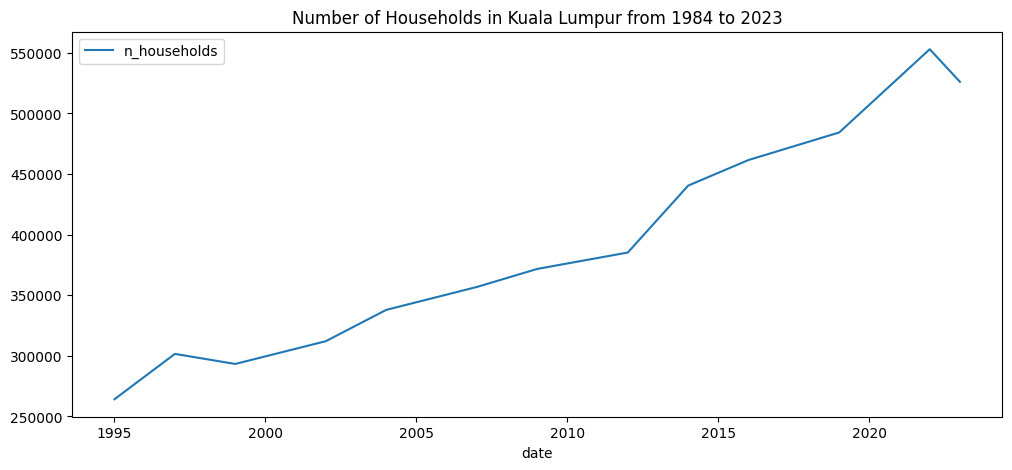

In [28]:
df_households.plot(
    x='date',
    y='n_households',
    figsize=(12,5),
    title='Number of Households in Kuala Lumpur from 1984 to 2023'
)

The number of household dropped, whereas the trend has been on the rise since 2000. Therefore, we try to use the time-weighted log-transformed regression to forecast the number of households.

In [29]:
df_households_weighted = df_income[['date', 'n_households']]
df_households_weighted = df_households_weighted.dropna().reset_index(drop=True)
df_households_weighted

,date,n_households
0,1995,264200.0
1,1997,301600.0
2,1999,293300.0
3,2002,312100.0
4,2004,337930.0
5,2007,356818.0
6,2009,371702.0
7,2012,385249.0
8,2014,440480.0
9,2016,461600.0


In [31]:
# Log-transformed Regression
# Step 1 and 2 omitted as the data is not expressed in the form of probability or rate
# Step 3: Compute corresponding weights for each observation

df_households_weighted['weights'] = (target_year - df_households_weighted['date'][0]) / (target_year - df_households_weighted['date'])

# Step 4: Sum the weights
sum_of_weights = df_households_weighted['weights'].sum()

# Step 5: Normalise each year
mean_year = df_households_weighted['date'].mean()
df_households_weighted['norm_year'] = df_households_weighted['date'] - mean_year

# Step 6: Calculate the slope and intercept of the linear regression line
df_households_weighted['wtL'] = df_households_weighted['weights'] * df_households_weighted['norm_year'] * df_households_weighted['n_households']
df_households_weighted['wt'] = df_households_weighted['weights'] * df_households_weighted['norm_year']
df_households_weighted['wL'] = df_households_weighted['weights'] * df_households_weighted['n_households']
df_households_weighted['wt2'] = df_households_weighted['weights'] * df_households_weighted['norm_year'] ** 2

term1 = df_households_weighted['wtL'].sum()
term2 = df_households_weighted['wt'].sum() * df_households_weighted['wL'].sum() / sum_of_weights
term3 = df_households_weighted['wt2'].sum()
term4 = df_households_weighted['wt'].sum() ** 2 / sum_of_weights

weighted_slope = (term1 - term2) / (term3 - term4)
print(f'Weighted slope: {weighted_slope}')

# Step 7: Extrapolate the number of households for 2023
number_of_households_extrapolated = round(weighted_slope * (target_year - mean_year) + intercept)
print(f'Number of households in 2023: {number_of_households_extrapolated}')

df_households_weighted.loc[len(df_households_weighted)] = [
    target_year,
    number_of_households_extrapolated,
    None,
    target_year - mean_year,
    None,
    None,
    None,
    None,
]
df_households_weighted

Weighted slope: 11605.519672809882
Number of households in 2023: 554273


,date,n_households,weights,norm_year,wtL,wt,wL,wt2
0,1995.0,264200.0,1.000000,-13.0,-3.434600e+06,-13.000000,2.642000e+05,169.000000
1,1997.0,301600.0,1.076923,-11.0,-3.572800e+06,-11.846154,3.248000e+05,130.307692
2,1999.0,293300.0,1.166667,-9.0,-3.079650e+06,-10.500000,3.421833e+05,94.500000
3,2002.0,312100.0,1.333333,-6.0,-2.496800e+06,-8.000000,4.161333e+05,48.000000
4,2004.0,337930.0,1.473684,-4.0,-1.992008e+06,-5.894737,4.980021e+05,23.578947
5,2007.0,356818.0,1.750000,-1.0,-6.244315e+05,-1.750000,6.244315e+05,1.750000
6,2009.0,371702.0,2.000000,1.0,7.434040e+05,2.000000,7.434040e+05,2.000000
7,2012.0,385249.0,2.545455,4.0,3.922535e+06,10.181818,9.806338e+05,40.727273
8,2014.0,440480.0,3.111111,6.0,8.222293e+06,18.666667,1.370382e+06,112.000000
9,2016.0,461600.0,4.000000,8.0,1.477120e+07,32.000000,1.846400e+06,256.000000


<Axes: title={'center': 'Number of Households in Kuala Lumpur from 1984 to 2023'}, xlabel='date'>

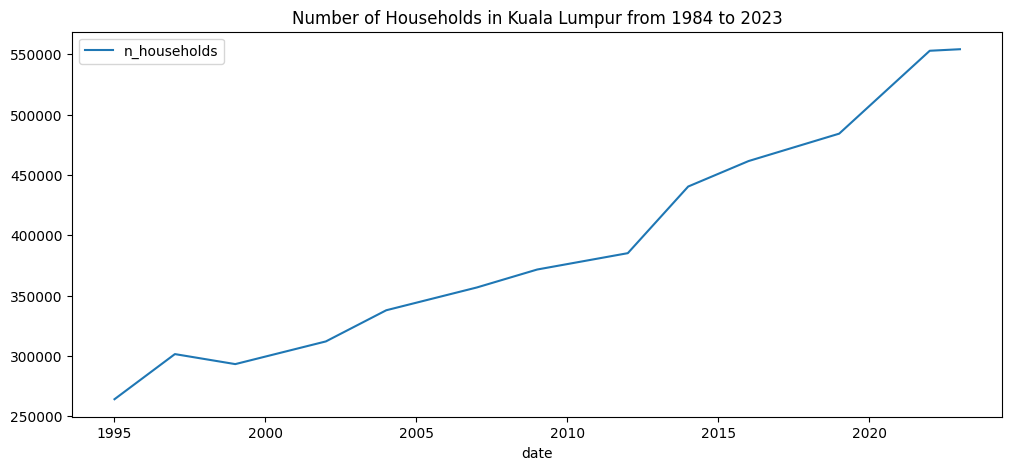

In [32]:
df_households_weighted.plot(
    x='date',
    y='n_households',
    figsize=(12,5),
    title='Number of Households in Kuala Lumpur from 1984 to 2023'
)

The time-weighted regression method made more sense. We will use this method.

### Backcasting

Unfortunately, these methods are only for extrapolating future values. One workaround as suggested on forums is inversing the data series (Stats StackExchange and StackOverflow) and forecast the "past values" using time series forecasting methods. However, many cautioned about the effectiveness of this method when used on small amount of data points, which is the case in our collected data. Therefore, we start by visually investigating the existing data to find any trend in the data. 

References:
- Stat StackExchange: https://stats.stackexchange.com/questions/190807/regression-on-default-data-and-backward-extrapolation
- StackOverflow: https://stackoverflow.com/questions/70768142/backcast-time-series-using-python